In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Data Preparation

### Demand

In [6]:
dem_unscalled = pd.read_csv('demand_unscalled.csv').rename(columns={'Unnamed: 0': 'h'}).set_index('h').dropna()

In [7]:
dem_unscalled.sum(axis=0)/1000000

2009    459.737428
2010    488.588700
2011    484.814086
2012    468.604944
2013    463.336853
2014    504.164821
2015    505.264563
2016    504.714786
2017    504.736369
dtype: float64

Total Demand ENTSOE factsheet

2009-2016
https://ag-energiebilanzen.de/7-0-Bilanzen-1990-2016.html

2016
https://www.entsoe.eu/publications/statistics-and-data/#statistical-factsheet

In [8]:
demTotENTSOE_powerStat = (dem_unscalled.sum(axis=0)/1000000).values
demTotENTSOE_factsheet = [495.2, 527.4, 521.2, 523.3, 523.2, 512.8, 514.7, 517.6, 538.7]
demScalled = dem_unscalled*(demTotENTSOE_factsheet/demTotENTSOE_powerStat)

In [9]:
demScalled.max(axis=0)

2009    78602.964647
2010    86229.627497
2011    82167.243796
2012    83167.640459
2013    85393.495777
2014    80475.142870
2015    78943.179714
2016    81516.278780
2017    84057.613386
dtype: float64

In [14]:
demScalled.to_csv('demand_scalled.csv')

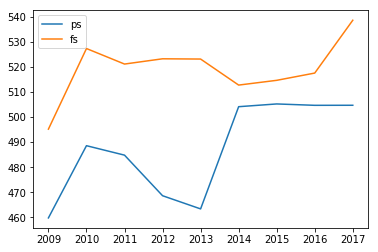

In [10]:
plt.plot(dem_unscalled.sum(axis=0)/1000000, label='ps')
plt.plot(demTotENTSOE_factsheet, label='fs')
plt.legend()
plt.show()

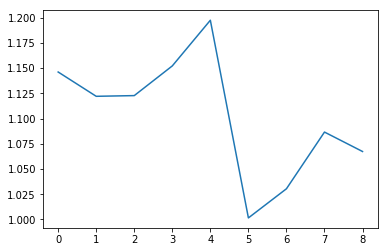

In [87]:
plt.plot(demTotENTSOE_factsheet/demTotENTSOE_powerStat)

In [94]:
demScalled.to_csv(os.path.abspath('demand_scalled.csv'))

## capacity Factors

### EMHIRES

In [7]:
pvCF = pd.read_csv(os.path.abspath('/Users/samarth/Desktop/Work/20.2_modelSandbox/05_mcELTRAMOD_2/mcData/01_resData/01_pv/1986.csv'))[['DE']].rename(columns={'DE':'1986'})
for year in range(1987,2016,1):
    pvCF = pvCF.join(pd.read_csv(os.path.abspath('/Users/samarth/Desktop/Work/20.2_modelSandbox/05_mcELTRAMOD_2/mcData/01_resData/01_pv/'+str(year)+'.csv'))[['DE']].rename(columns={'DE':str(year)}))

#pvCF.to_csv(os.path.abspath('/Volumes/Mitarbeiter/Austausch/2019_coalPhaseOut/Res_CF/pvCF.csv'))

In [8]:
wonCF = pd.read_csv(os.path.abspath('/Users/samarth/Desktop/Work/20.2_modelSandbox/05_mcELTRAMOD_2/mcData/01_resData/02_won/1986.csv'))[['DE']].rename(columns={'DE':'1986'})
for year in range(1987,2016,1):
    wonCF = wonCF.join(pd.read_csv(os.path.abspath('/Users/samarth/Desktop/Work/20.2_modelSandbox/05_mcELTRAMOD_2/mcData/01_resData/02_won/'+str(year)+'.csv'))[['DE']].rename(columns={'DE':str(year)}))

#wonCF.to_csv(os.path.abspath('/Volumes/Mitarbeiter/Austausch/2019_coalPhaseOut/Res_CF/wonCF.csv'))

In [9]:
woffCF = pd.read_csv(os.path.abspath('/Users/samarth/Desktop/Work/20.2_modelSandbox/05_mcELTRAMOD_2/mcData/01_resData/03_woff/1986.csv'))[['DE']].rename(columns={'DE':'1986'})
for year in range(1987,2016,1):
    woffCF = woffCF.join(pd.read_csv(os.path.abspath('/Users/samarth/Desktop/Work/20.2_modelSandbox/05_mcELTRAMOD_2/mcData/01_resData/03_woff/'+str(year)+'.csv'))[['DE']].rename(columns={'DE':str(year)}))

#woffCF.to_csv(os.path.abspath('/Volumes/Mitarbeiter/Austausch/2019_coalPhaseOut/Res_CF/woffCF.csv'))

In [10]:
pvCFMeera = pd.read_csv(os.path.abspath('/Users/samarth/Desktop/Work/20.2_modelSandbox/05_mcELTRAMOD_2/mcData/01_resData/01_pv/1986_ninjaMeera.csv'))[['DE']].rename(columns={'DE':'1986'})
for year in range(1987,2016,1):
    pvCFMeera = pvCFMeera.join(pd.read_csv(os.path.abspath('/Users/samarth/Desktop/Work/20.2_modelSandbox/05_mcELTRAMOD_2/mcData/01_resData/01_pv/'+str(year)+'_ninjaMeera.csv'))[['DE']].rename(columns={'DE':str(year)}))
    
#pvCFMeera.to_csv(os.path.abspath('Res_CF/pvCF_NinjaMeera.csv'))

In [11]:
wonCFNinja = pd.read_csv(os.path.abspath('/Users/samarth/Desktop/Work/20.2_modelSandbox/05_mcELTRAMOD_2/mcData/01_resData/02_won/1986_ninja.csv'))[['DE']].rename(columns={'DE':'1986'})
for year in range(1987,2016,1):
    wonCFNinja = wonCFNinja.join(pd.read_csv(os.path.abspath('/Users/samarth/Desktop/Work/20.2_modelSandbox/05_mcELTRAMOD_2/mcData/01_resData/02_won/'+str(year)+'_ninja.csv'))[['DE']].rename(columns={'DE':str(year)}))
    
#wonCFNinja.to_csv(os.path.abspath('Res_CF/wonCF_Ninja.csv'))

In [12]:
woffCFNinja = pd.read_csv(os.path.abspath('/Users/samarth/Desktop/Work/20.2_modelSandbox/05_mcELTRAMOD_2/mcData/01_resData/03_woff/1986_ninja.csv'))[['DE']].rename(columns={'DE':'1986'})
for year in range(1987,2016,1):
    woffCFNinja = woffCFNinja.join(pd.read_csv(os.path.abspath('/Users/samarth/Desktop/Work/20.2_modelSandbox/05_mcELTRAMOD_2/mcData/01_resData/03_woff/'+str(year)+'_ninja.csv'))[['DE']].rename(columns={'DE':str(year)}))
    
#woffCFNinja.to_csv(os.path.abspath('Res_CF/woffCF_Ninja.csv'))

# Reading Data

## Demand

In [2]:
demandAll = pd.read_csv('demand_scalled.csv').rename(columns={'Unnamed: 0':'h'}).set_index('h')

In [3]:
demandAll.sum(axis=0)/1000000

2009    495.2
2010    527.4
2011    521.2
2012    523.3
2013    523.2
2014    512.8
2015    514.7
2016    517.6
2017    538.7
dtype: float64

In [4]:
demandAll.max(axis=0)/1000

2009    78.602965
2010    86.229627
2011    82.167244
2012    83.167640
2013    85.393496
2014    80.475143
2015    78.943180
2016    81.516279
2017    84.057613
dtype: float64

## Capacity Factors

In [5]:
pvCF = pd.read_csv(os.path.abspath('Res_CF/pvCF_EMIHRES.csv'))
wonCF = pd.read_csv(os.path.abspath('Res_CF/wonCF_EMIHRES.csv'))
woffCF = pd.read_csv(os.path.abspath('Res_CF/woffCF_EMIHRES.csv'))

pvCFMeera = pd.read_csv(os.path.abspath('Res_CF/pvCF_NinjaMeera.csv'))
wonCFNinja = pd.read_csv(os.path.abspath('Res_CF/wonCF_Ninja.csv'))
woffCFNinja = pd.read_csv(os.path.abspath('Res_CF/woffCF_Ninja.csv'))

# Analysis

### Best case

In [6]:
pvCap_b   = 50334 
wonCap_b  = 64691 
woffCap_b =  9446
reliableCap_b = 75547

In [7]:
pvCap_b_ne   = 50334 
wonCap_b_ne  = 64691 
woffCap_b_ne =  9446
reliableCap_b_ne = 78547

In [8]:
pvCap_w   = 50334 
wonCap_w  = 54691 
woffCap_w =  7127
reliableCap_w = 68621

In [9]:
outLoc ='/Users/samarth/Desktop/Work/24_coalPhaseOut/draft/'

In [10]:
def getResLoad(pvCap, wonCap, woffCap):
    resLoad = pd.DataFrame()
    for demYear in demandAll:
        for wYear in range(1986,2016,1):
            insRESLoad = pd.DataFrame(demandAll[str(demYear)] - 
                                      pvCF[str(wYear)]*pvCap-
                                      wonCF[str(wYear)]*wonCap-
                                      woffCF[str(wYear)]*woffCap, columns=[str(demYear)+'_'+str(wYear)])
            resLoad = resLoad.join(insRESLoad, how='outer')
    
    for demYear in demandAll:
        for wYear in range(1986,2016,1):
            insRESLoad = pd.DataFrame(demandAll[str(demYear)] - 
                                      pvCFMeera[str(wYear)]*pvCap-
                                      wonCFNinja[str(wYear)]*wonCap-
                                      woffCFNinja[str(wYear)]*woffCap, columns=[str(demYear)+'_'+str(wYear)+'_ninja'])
            resLoad = resLoad.join(insRESLoad, how='outer')
    return resLoad

In [11]:
resLoad_b  = getResLoad(pvCap_b,wonCap_b,woffCap_b)
resLoad_w  = getResLoad(pvCap_w,wonCap_w,woffCap_w)

In [12]:
def plotResLoad(resLoad, reliableCap):
    resLoadSort = resLoad.values
    resLoadSort.sort(axis=0)
    plt.plot(resLoadSort, color='b',alpha=0.01);
    plt.hlines(reliableCap, xmin=0, xmax=8760)
    plt.xlim([])
    plt.show()

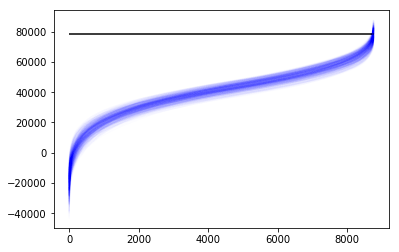

In [132]:
plotResLoad(resLoad_b, reliableCap_b)

In [25]:
def getMaxResLoads(resLoad):
    maxLoads = []
    for col in resLoad.columns:
        maxLoads.append(resLoad[col].max())
        
    return maxLoads

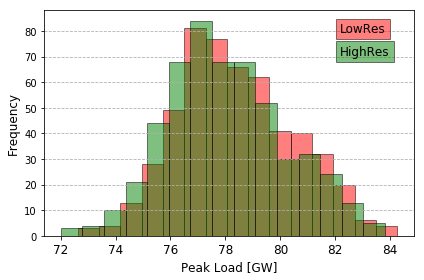

In [275]:
fig, ax = plt.subplots()
maxValues_w = getMaxResLoads(resLoad_w)
(pd.DataFrame(maxValues_w)/1000).plot(kind='hist', bins=15, ax=ax,
                                     # label='highRes', 
                                    legend=False,
                                     edgecolor='k', color='red', alpha=0.5)

maxValues_b = getMaxResLoads(resLoad_b)
(pd.DataFrame(maxValues_b)/1000).plot(kind='hist', bins=15, ax=ax,
                                      #label='lowRes',
                                      legend=False,
                                    edgecolor='k', color='green', alpha=0.5)
plt.ylabel('Frequency', size=12)
plt.xlabel('Peak Load [GW]', size=12)
plt.xticks(size=12)
plt.grid( axis='y', linestyle = '--')
plt.tight_layout()
#plt.savefig(outLoc+'/PeakLoadDiss.pdf')

t = plt.text(0.8, 0.90, 'LowRes', transform=ax.transAxes, fontsize=12)
t.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='black'))

t = plt.text(0.8, 0.80, 'HighRes', transform=ax.transAxes, fontsize=12)
t.set_bbox(dict(facecolor='green', alpha=0.5, edgecolor='black'))

plt.savefig(outLoc+'/PeakLoadDiss.pdf')
plt.show()


## consecutive hours

In [13]:
def getContStressStat(resLoad, reliableCap):
    resLoadStress = resLoad.copy()
    resLoadStress[resLoad < reliableCap] = 0
    
    conStat = []
    
    for col in resLoadStress.columns:
        resLoadIns = resLoadStress[col].values
        counter_noStress = 0
        for i in range(0,len(resLoadIns),1):

            if resLoadIns[i]==0:
                counter_stress = 0
                excessEnergy = 0
                counter_noStress = counter_noStress + 1 
                
            else:
                counter_stress = counter_stress + 1
                excessEnergy = excessEnergy + resLoadIns[i] - reliableCap
                conStat.append([counter_stress, excessEnergy,resLoadIns[i] - reliableCap, i, counter_noStress+1])
                counter_noStress=0
                
    conStressHoursStat = pd.DataFrame(conStat, 
                                      columns=['conNumHours','excessLoad', 'excessCap','hour','hoursSinceLastStress'])
    instanceCount = 0
    instanceList = []

    for row in conStressHoursStat.iterrows():
        if row[1][0]==1:
            instanceCount=instanceCount+1
        instanceList.append(instanceCount)
        
    conStressHoursStat['instanceCount'] = instanceList
    
    maxInfoStressInstance = []
    for instance in range(1,conStressHoursStat['instanceCount'].max(), 1):
        instanceInfo = conStressHoursStat.loc[conStressHoursStat['instanceCount']==instance]
        maxInfoStressInstance.append([instanceInfo['conNumHours'].max(), 
                                      instanceInfo['excessLoad'].max()/1000, 
                                      instanceInfo['hoursSinceLastStress'].max()])

    stressHMaxChar = pd.DataFrame(maxInfoStressInstance, columns=['hours','TotEnergy','hoursSinceLast'])
    
    return conStressHoursStat, stressHMaxChar

In [14]:
#conStressHour_b, stressHMaxChar_b = getContStressStat(resLoad_b.dropna(axis=1), reliableCap_b)
conStressHour_b_ne, stressHMaxChar_b_ne = getContStressStat(resLoad_b.dropna(axis=1), reliableCap_b_ne)

In [44]:
conStressHour_w, stressHMaxChar_w = getContStressStat(resLoad_b.dropna(axis=1), reliableCap_w)

### Adding maxLAR at to the stress instance characters

In [69]:
stressHMaxChar_w['LAR_max [GW]'] = conStressHour_w[['instanceCount','excessCap']].groupby('instanceCount').max()['excessCap']/1000

In [61]:
stressHMaxChar_w['LAR_mean'] = conStressHour_w[['instanceCount','excessCap']].groupby('instanceCount').mean()['excessCap']/1000

In [52]:
totEnergy2 =[]
hours2 = []
for index, row in stressHMaxChar_w.iterrows():
    if row[2]<=12:
        totEnergy2.append(row[1]+stressHMaxChar_w.xs(index-1)[1])
        hours2.append(row[0]+stressHMaxChar_w.xs(index-1)[0])
    else:
        totEnergy2.append(row[1])
        hours2.append(row[0])

stressHMaxChar_w['TotEnergy_2'] = totEnergy2
stressHMaxChar_w['hours_2'] = hours2

In [48]:
def strHours_hoursSinceLast(stressHMaxChar):
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    stressHMaxChar.plot(kind='scatter', x='hours', 
                          y='hoursSinceLast',
                        ax=ax1,
                        color='k')
    
    meanHoursLast = stressHMaxChar[['hours', 'hoursSinceLast']].groupby('hours').mean()
    
    stressHMaxChar[['hours', 
                    'hoursSinceLast']].groupby('hours').mean().reset_index().plot(kind='scatter', 
                                                                                  x='hours',y='hoursSinceLast', 
                                                                                  ax=ax2)
    
    # linear regression
#    X_hours = np.array([stressHMaxChar['hours'].values]).T
#    y_hSinceLast = stressHMaxChar['hoursSinceLast'].values
#    regr = linear_model.LinearRegression()
#    regr.fit( X = X_hours, 
#              y = y_hSinceLast)
#    y_predHourSinceLast = regr.predict(np.array([np.arange(0,21,1)]).T)



#    ax2.plot(y_predHourSinceLast, linewidth=3)#
#
#    ax2.legend(['mean HoursSinceLast'])
    ax1.set_ylim([0,5000
                 ])
    ax1.set_xlim([0,19])
    ax2.set_ylim([0,250])
    plt.xticks(np.arange(0,21,1));

In [73]:
def pltHourScatter(stressHMaxChar):
    
    fig, ax1 = plt.subplots(sharex=True)
#    ax2 = ax1.twinx()
#    stressHMaxChar.groupby('hours').count().rename(columns={'hoursSinceLast':'count'}).plot(kind='bar', y='count',
#                                                                                           ax=ax1
#                                                                                           )
#    ax1.set_xlim([0,19])
    days = (stressHMaxChar.hoursSinceLast/24).astype(int)
    days[days>7]=7
    stressHMaxChar.plot.scatter(x='hours_2', y='TotEnergy_2', colormap='Reds',
                        c='LAR_max [GW]', ax=ax1, 
                        alpha=0.5)
    
    #ax1.set_ylim([0,200000])
    ax1.axhline(y=58, xmin=0, xmax=19,
               linewidth=2, color='k')
    #ax1.set_xlim([0,19])
    plt.ylabel('Energy At Risk (EAR) [GWh]')
    plt.xlabel('Consecutive Load At Risk (LAR) Hours')
    #plt.xticks(np.arange(0,20,1));
    plt.tight_layout()
    #plt.savefig(outLoc+'/energyHours_dis.pdf')

In [84]:
(stressHMaxChar_w.loc[stressHMaxChar_w['TotEnergy_2']>53]['TotEnergy_2']-53).std()

35.69115854713364

In [77]:
stressHMaxChar_w.loc[stressHMaxChar_w['TotEnergy_2']>53]['hours_2'].std()

5.742239965008204

In [32]:
stressHMaxChar_w.head()

,hours,TotEnergy,hoursSinceLast,maxCap,TotEnergy_2,hours_2
0,1,0.532916,163,NaN,0.532916,1.0
1,1,0.764750,24,532.915791,0.764750,1.0
2,2,2.006933,431,764.749601,2.006933,2.0
3,3,11.748952,215,1792.490666,11.748952,3.0
4,1,0.417774,46,5705.941496,0.417774,1.0


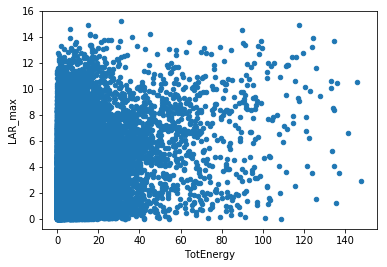

In [68]:
stressHMaxChar_w.plot.scatter(x='TotEnergy',y='LAR_max')

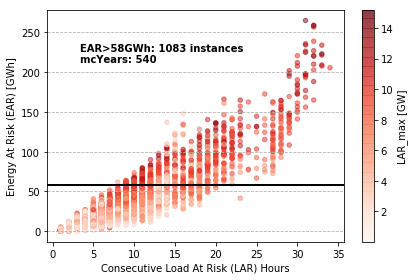

In [74]:
pltHourScatter(stressHMaxChar_w)

plt.text(0.1*stressHMaxChar_w['hours_2'].max(), 
         0.8*stressHMaxChar_w['TotEnergy_2'].max(),
         s='EAR>58GWh: 1083 instances\nmcYears: 540',
         fontweight='bold'
        )

plt.grid(axis='y',linestyle='--')
plt.savefig(outLoc+'/hours_energyAtRisk_noPump_4.pdf')
#pltHourScatter(stressHMaxChar_b_ne)
#plt.text(x=22.5, y=28,s= 'Days since last stress', rotation=90)
#plt.grid( axis='y', linestyle='--')
#plt.savefig(outLoc+'/hours_energyAtRisk_Pump.pdf')
#pltHourScatter(stressHMaxChar_b_ne)

In [194]:
conStressHour.head()

,conNumHours,excessLoad,excessCap,hour,hoursSinceLastStress
0,1,1217.402269,1217.402269,113,114
1,2,1470.618459,253.216190,114,1
2,1,3876.309852,3876.309852,137,23
3,2,8785.497318,4909.187466,138,1
4,3,10731.551839,1946.054520,139,1


In [150]:
def scatterHours(conStressHour):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    #plt.hist(conStressHour['conNumHours'].values, bins=bins, 
    #                                  align='left',
    #                                  axes=ax1, 
    #                                  color='#CD6155',
    #                                  alpha=0.4)

    conStressHour.plot(kind='scatter', 
                       x='conNumHours',y='excessLoad',
                       alpha=0.1, ax=ax2, color='k')
    #ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.savefig('frey_excessEnergy.pdf')
    plt.show()

# Hours at Risk

In [104]:
def hoursAtRisk(resLoad, reliableCap, saveFig, figName, color, case):
    hoursAtRisk = (resLoad>reliableCap).sum()
    stat = case + ' \nmean:%.2f \nstd: %.2f'% (hoursAtRisk.mean(), hoursAtRisk.std())
    plt.hist(hoursAtRisk, bins=15, label=stat, 
             edgecolor='black', color=color, alpha=0.7)
    plt.xlabel('Hours at Risk [h]', size=12)
    plt.ylabel('Frequency', size=12)
    plt.legend()
    
    plt.tight_layout()
    if saveFig:
        plt.savefig(outLoc+'/'+figName)
    #plt.show()

In [108]:
c_withoutPump = '#C0392B'
c_withPump = '#16A085'

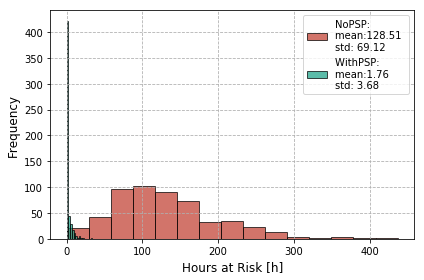

In [267]:
hoursAtRisk(resLoad_b,reliableCap_w, saveFig=False, 
            figName='HoursAtRisk_withoutPump.pdf', color=c_withoutPump, case='NoPSP: ')
hoursAtRisk(resLoad_b,reliableCap_b_ne, saveFig=False, 
            figName='HoursAtRisk_withPump.pdf', color=c_withPump, case='WithPSP: ')
plt.grid(linestyle='--')
plt.savefig(outLoc+'/'+'HoursAtRisk_sc.pdf')

## Maximum Load at Risk

/Users/samarth/miniconda3/envs/mcELTRAMOD/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/samarth/miniconda3/envs/mcELTRAMOD/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


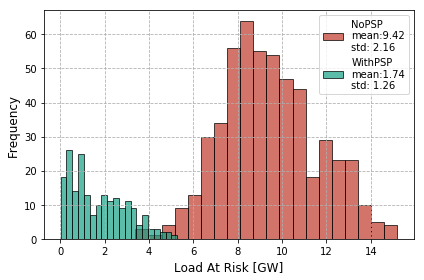

In [268]:
def maxLoadRisk(resLoad, reliableCap, saveFig, figName, color, case):
    loadAtRisk = ((resLoad[resLoad>reliableCap] - reliableCap)/1000).max()
    stat = case+'\nmean:%.2f\nstd: %.2f'% (loadAtRisk.mean(), loadAtRisk.std())
    plt.hist(loadAtRisk, bins=20, label=stat,  
             edgecolor='black', color=color, alpha=0.7)
    plt.xlabel('Load At Risk [GW]', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    #plt.xlim([0,20])
    #plt.ylim([0,60])
    plt.legend()
    plt.tight_layout()
    if saveFig:
        plt.savefig(outLoc+"/"+figName)
    
    
maxLoadRisk(resLoad_b, reliableCap_w, saveFig=False, figName='as', 
            color=c_withoutPump, case='NoPSP')
maxLoadRisk(resLoad_b, reliableCap_b_ne, saveFig=False, figName='as', 
            color=c_withPump, case='WithPSP')
plt.grid(linestyle='--')
plt.savefig(outLoc+'/MaxLoadAtRisk.pdf')

## Energy at risk

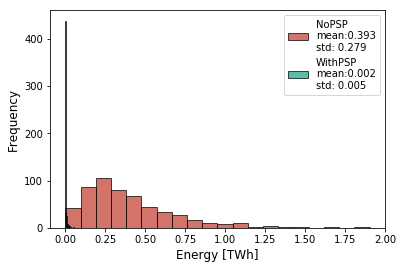

In [270]:
def energyAtRisk(resLoad, reliableCap, color, case, saveFig=False, figName=False):
    energyAtRisk=((resLoad[resLoad>reliableCap] - reliableCap)/1000000).sum()
    stat = case+'\nmean:%.3f\nstd: %.3f'% (energyAtRisk.mean(), energyAtRisk.std())
    plt.hist(energyAtRisk, bins=20, label=stat,  
             edgecolor='black', color=color, alpha=0.7)
    plt.xlabel('Energy [TWh]', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    #plt.show()
    
energyAtRisk(resLoad_b, reliableCap_w, color=c_withoutPump, case='NoPSP')
energyAtRisk(resLoad_b, reliableCap_b_ne, color=c_withPump, case='WithPSP')

plt.savefig(outLoc+'/EnergyAtRisk.pdf')